In [ ]:
!pip install darts
!pip install pyyaml==5.4.1
!pip install -q xlrd
!pip install matplotlib==3.1.1

     |████████████████████████████████| 370 kB 4.3 MB/s 
     |████████████████████████████████| 11.2 MB 49.6 MB/s 
     |████████████████████████████████| 1.4 MB 39.9 MB/s 
     |████████████████████████████████| 9.8 MB 22.5 MB/s 
     |████████████████████████████████| 584 kB 49.6 MB/s 
     |████████████████████████████████| 65 kB 2.9 MB/s 
     |████████████████████████████████| 793 kB 40.9 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 172 kB 44.5 MB/s 
     |████████████████████████████████| 381 kB 41.3 MB/s 
     |████████████████████████████████| 930 kB 35.9 MB/s 
     |████████████████████████████████| 49 kB 4.0 MB/s 
     |████████████████████████████████| 45 kB 1.5 MB/s 
     |████████████████████████████████| 596 kB 44.2 MB/s 
     |████████████████████████████████| 408 kB 47.6 MB/s 
     |████████████████████████████████| 136 kB 44.3 MB/s 
     |████████████████████████████████| 1.1 MB 41.2 MB/s 
     |████████████████

     |████████████████████████████████| 636 kB 4.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 16.7 MB 331 kB/s 
     |████████████████████████████████| 6.3 MB 11.8 MB/s 
     |████████████████████████████████| 46 kB 92 kB/s 
     |████████████████████████████████| 2.0 MB 4.3 MB/s 
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.1.post1
    Uninstalling Shapely-1.8.1.post1:
      Successfully uninstalled Shapely-1.8.1.post1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel
from darts.metrics import mape, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE_DATE_NUM = "/drive/MyDrive/TForm_DN_mode001e.pth.tar"   # file name to save the model under

EPOCHS = 100
INLEN = 32          # input size
FEAT = 32           # d_model = number of expected features in the inputs, up to 512    
HEADS = 4           # default 8
ENCODE = 4          # encoder layers
DECODE = 4          # decoder layers
DIM_FF = 128        # dimensions of the feedforward network, default 2048
BATCH = 32          # batch size
ACTF = "relu"       # activation function, relu (default) or gelu
SCHLEARN = None     # a PyTorch learning rate scheduler; None = constant rate
LEARN = 1e-3        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
DROPOUT = 0.1       # dropout rate
N_FC = 1            # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = 3          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

mpath_date_num = os.path.abspath(os.getcwd()) + SAVE_DATE_NUM     # path and file name to save the model

In [ ]:
ds = pd.read_excel("/content/drive/MyDrive/CSUEB/capstone/data/v14.1.xlsx")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95394 entries, 0 to 95393
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   iyear              95394 non-null  int64  
 1   imonth             95394 non-null  int64  
 2   iday               95394 non-null  int64  
 3   date_num           95394 non-null  int64  
 4   extended           95394 non-null  int64  
 5   hdi2019            95394 non-null  float64
 6   unemployment_rate  95394 non-null  float64
 7   country            95394 non-null  int64  
 8   region             95394 non-null  int64  
 9   latitude           95394 non-null  float64
 10  longitude          95394 non-null  float64
 11  specificity        95394 non-null  int64  
 12  vicinity           95394 non-null  int64  
 13  crit1              95394 non-null  int64  
 14  crit2              95394 non-null  int64  
 15  crit3              95394 non-null  int64  
 16  doubtterr          953

In [ ]:
df = pd.DataFrame(ds)
df.index = pd.RangeIndex(start=0, stop=95394, step=1)

In [ ]:
# Feature corelated to date_num
ds_dn = df[["date_num","iyear","claimed","nkillter","nwoundte","corp1",
            "country_type","region","unemployment_rate","longitude"]]

df_dn = pd.DataFrame(ds_dn)
df_dn.index = pd.RangeIndex(start=0, stop=95394, step=1)

# create time series object for target variable
ts_DN = TimeSeries.from_series(df_dn["date_num"]) 

# create time series object for the feature columns
df_covF_DN = df_dn.loc[:, df_dn.columns != "date_num"]
ts_covF_DN = TimeSeries.from_dataframe(df_covF_DN)

In [ ]:
# train/test split
ts_train_dn, ts_test_dn = ts_DN.split_after(SPLIT)

In [ ]:
# scaling of target variable
scalerDN = Scaler()
scalerDN.fit_transform(ts_train_dn)
ts_ttrain_dn = scalerDN.transform(ts_train_dn)
ts_ttest_dn = scalerDN.transform(ts_test_dn)    
ts_t_dn = scalerDN.transform(ts_DN)

# make sure data are of type float
ts_t_dn = ts_t_dn.astype(np.float32)
ts_ttrain_dn = ts_ttrain_dn.astype(np.float32)
ts_ttest_dn = ts_ttest_dn.astype(np.float32)

print("first and last row of scaled target time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t_dn.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target time series:


component,date_num
time,
0,0.0000
95393,1.0545


In [ ]:
# train/test split and scaling of feature covariates for date_num
covF_train_dn, covF_test_dn = ts_covF_DN.split_after(SPLIT)

scalerF_DN = Scaler()
scalerF_DN.fit_transform(covF_train_dn)
covF_ttrain_dn = scalerF_DN.transform(covF_train_dn) 
covF_ttest_dn = scalerF_DN.transform(covF_test_dn)   
covF_t_dn = scalerF_DN.transform(ts_covF_DN)  

# make sure data are of type float
covF_ttrain_dn = ts_ttrain_dn.astype(np.float32)
covF_ttest_dn = ts_ttest_dn.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t_dn.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component,iyear,claimed,nkillter,nwoundte,corp1,country_type,region,unemployment_rate,longitude
time,,,,,,,,,
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6364,0.9466,0.8686
95393,1.0426,0.9990,0.8802,0.8695,0.6748,1.0000,0.4545,0.9564,0.9009


In [ ]:
model = TransformerModel(
                    input_chunk_length = INLEN,
                    output_chunk_length = N_FC,
                    batch_size = BATCH,
                    n_epochs = EPOCHS,
                    model_name = "Transformer_multivariate_timeseries",
                    nr_epochs_val_period = VALWAIT,
                    d_model = FEAT,
                    nhead = HEADS,
                    num_encoder_layers = ENCODE,
                    num_decoder_layers = DECODE,
                    dim_feedforward = DIM_FF,
                    dropout = DROPOUT,
                    activation = ACTF,
                    random_state=RAND,
                    likelihood=QuantileRegression(quantiles=QUANTILES), 
                    optimizer_kwargs={'lr': LEARN},
                    add_encoders={"cyclic": {"future": ["iyear","date_num"]},
                                  'datetime_attribute': {'future': ['iyear']},},
                    save_checkpoints=True,
                    force_reset=True
                    )

In [ ]:
# model for date_num
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath_date_num)
    model_DN = TransformerModel.load_model(mpath_date_num)                            # load previously model from disk 
else:
    model_DN = model
    model_DN.fit( ts_ttrain_dn,verbose=True)
    print("have saved the model after training:", mpath_date_num)
    model_DN.save_model(mpath_date_num)

Training: 0it [00:00, ?it/s]

have saved the model after training: /content/drive/MyDrive/TForm_DN_mode002e_testing01.pth.tar


In [ ]:
# Prediction of date_num
ts_tpred_dn = model_DN.predict(   n=len(ts_ttest_dn), 
                            num_samples=N_SAMPLES,   
                            n_jobs=N_JOBS, 
                            verbose=True)

Predicting: 2682it [00:00, ?it/s]

In [ ]:
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None

pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY[["date_num"]] = TimeSeries.pd_dataframe(ts_test_dn)

def predQ(ts_t, q, val):
    ts_tq = ts_t.quantile_timeseries(q) 
    if val==0:
      ts_q = scalerDN.inverse_transform(ts_tq)
      header = "date_num" + format(int(q*100), "02d")
      ts_test_ = ts_test_dn

    s = TimeSeries.pd_dataframe(ts_q) 
    dfY[[header]] = s
    if q==0.5:
        ts_q50 = ts_q
        q50_RMSE = rmse(ts_q50, ts_test_)
        q50_MAPE = mape(ts_q50, ts_test_)
        print("RMSE 50:", f'{q50_RMSE:.2f}')
        print("MAPE 50:", f'{q50_MAPE:.2f}')
   

# call helper function predQ, once for every quantile
_DN = [predQ(ts_tpred_dn, q, 0) for q in QUANTILES]

dfY.to_excel('/content/drive/MyDrive/CSUEB/capstone/data/DNtranform_001.xlsx')

0.01
RMSE: 0.0541
0.1
RMSE: 0.0472
0.2
RMSE: 0.0448
0.5
RMSE: 0.0383
0.8
RMSE: 0.0288
0.9
RMSE: 0.0263
0.99
RMSE: 0.0208


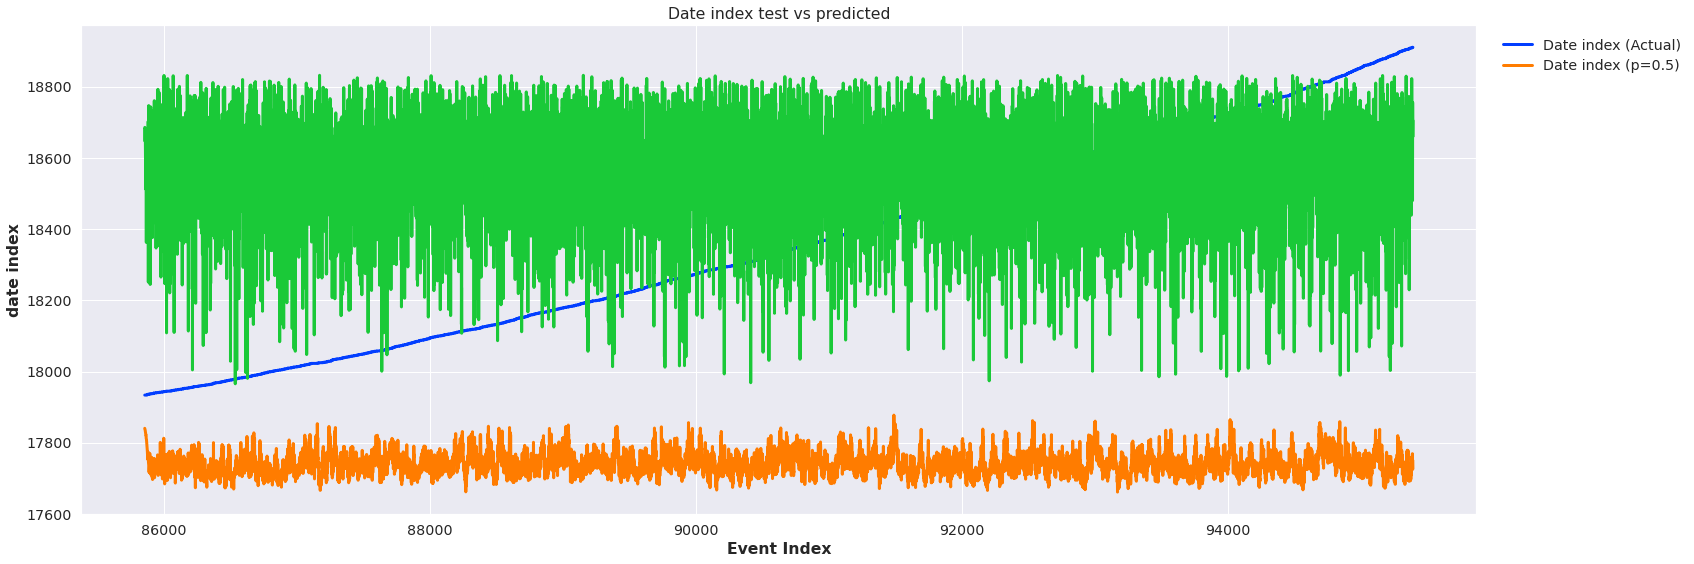

In [ ]:
# plot the forecast
plt.figure(100, figsize=(25, 9))
sns.set(font_scale=1.3)
sns.set_palette("bright")
D = dfY[0:50]

p = sns.lineplot(x = "time", y = "date_num", data = D, linewidth = 3 )
sns.lineplot(x = "time", y = "date_num50", data = D, linewidth = 3)
plt.legend(labels=[ "Date index (Actual)","Date index (p=0.5)",],
           bbox_to_anchor=(1.01, 1.0), loc='upper left')

p.set_ylabel("date index")
p.set_xlabel("Event Index")
p.set_title("Date index test vs predicted");

In [ ]:
k = 365*5   

n_FC = k + len(ts_ttest_dn)   # length of test set + k events
print("forecast beyond end of training set:", n_FC)

forecast beyond end of training set: 11365


In [ ]:
# forecast from end of training set until k hours beyond end of test set
ts_tpred = model_DN.predict(   n=n_FC, 
                            num_samples=N_SAMPLES, 
                            verbose=True, 
                            n_jobs=N_JOBS)

Predicting: 2682it [00:00, ?it/s]

In [ ]:
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None

pd.options.display.float_format = '{:,.4f}'.format
dfY = pd.DataFrame()
dfY[["date_num"]] = TimeSeries.pd_dataframe(ts_test_dn)

_DN = [predQ(ts_tpred, q, 0) for q in QUANTILES]

dfY.to_excel('/content/drive/MyDrive/CSUEB/capstone/data/DNtranform_fut1.xlsx')

RMSE 50: 686.7042
MAPE 50: 3.5188


         date_num  date_num01  date_num10  date_num20  date_num50  date_num80  \
time                                                                            
95389 18,911.0000 17,416.0722 17,593.9179 17,630.5919 17,713.2421 17,899.8188   
95390 18,911.0000 17,426.9796 17,587.5639 17,645.9224 17,721.3450 17,919.8478   
95391 18,911.0000 17,438.1641 17,594.0870 17,622.7303 17,719.1218 17,947.5387   
95392 18,911.0000 17,462.4467 17,576.1899 17,623.4588 17,714.9683 17,931.0906   
95393 18,911.0000 17,457.8598 17,586.1053 17,627.5729 17,713.6638 17,947.2210   

       date_num90  date_num99  
time                           
95389 17,950.4747 18,429.1751  
95390 17,972.3573 18,567.7858  
95391 18,112.6875 18,676.9543  
95392 17,966.0685 18,671.3265  
95393 18,018.7598 18,668.9117  


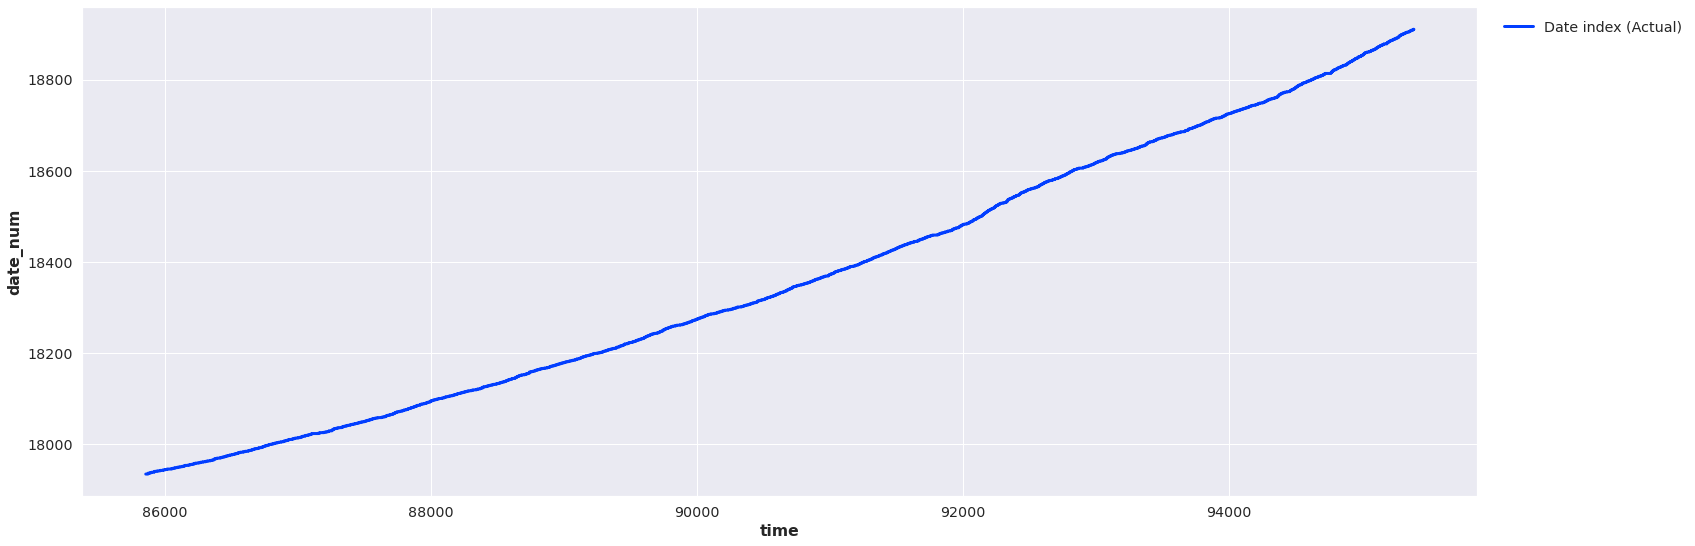

In [ ]:
# plot the forecast
plt.figure(100, figsize=(25, 9))
sns.set(font_scale=1.3)
sns.set_palette("bright")
D = dfY[0:50]
p = sns.lineplot(x = "time", y = "date_num", data = D, linewidth = 3)
sns.lineplot(x = "time", y = "date_num50", data = D, linewidth = 3)
plt.legend(labels=[ "Date index (Actual)","Date index (p=0.5)",],
           bbox_to_anchor=(1.01, 1.0), loc='upper left')

p.set_ylabel("date index")
p.set_xlabel("Event Index")
p.set_title("Date index test vs predicted");